# Image Segmentation Using CNN

**Esther SunYoung CHOI**

The goal is to build and train a convolutional neural network with a U-Net architecture to perform image segmentation.

To do so, we will use the Oxford-IIIT Pet dataset that contains color images of 37 pet breeds with their corresponding mask, which is an array of the same size as the images, and contains either the values 1, 2 or 3 that code for a different part of the picture.
- Class 1 : pixels belonging to the pet
- Class 2 : pixels bordering the pet
- Class 3 : other pixels


## Prerequisite Python Modules

In [ ]:
! pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-kmrwzreb
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-kmrwzreb
  Created wheel for tensorflow-examples: filename=tensorflow_examples-26080748173cc8236f805d2b65031b1e39fde4b1_-py3-none-any.whl size=299671 sha256=ad243fece2807df1d916a9cbe307888b93ea97b8f7b80a38624fba7df992f4e7
  Stored in directory: /tmp/pip-ephem-wheel-cache-74utn0_v/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/i

In [ ]:
import tensorflow as tf

import tensorflow_datasets as tfds

from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Importing the dataset

We will use the Oxford-IIIT Pet dataset.

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteZGD7Y9/oxford_iiit_pet-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteZGD7Y9/oxford_iiit_pet-test.tfrecord*...:   0%…

Dataset oxford_iiit_pet downloaded and prepared to ~/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


We are going to do some preprocessing on the data.

- The function `normalize` rescales the values to [0,1] and renames the label {0,1,2} instead of {1,2,3}.
- The function `load_image` reshapes the image and apply normalization.
- The class `Augment` randomnly performs a flip on images, so that pets face left or right.

We will keep the train and test split given by the dataset.

In [ ]:
# Preprocessing
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

# Defining batch length
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# Getting train and test images
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

# Simple Augmentation
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels


We build the input pipeline that creates all the batches and apply the previous augmentation.

In [ ]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_batches = test_images.batch(BATCH_SIZE)

We can now display some examples : on the left we have the original image, and on the right we have the corresponding mask.

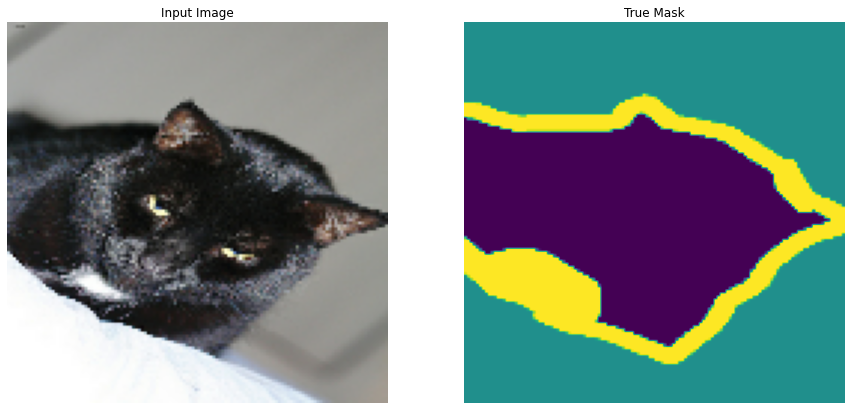

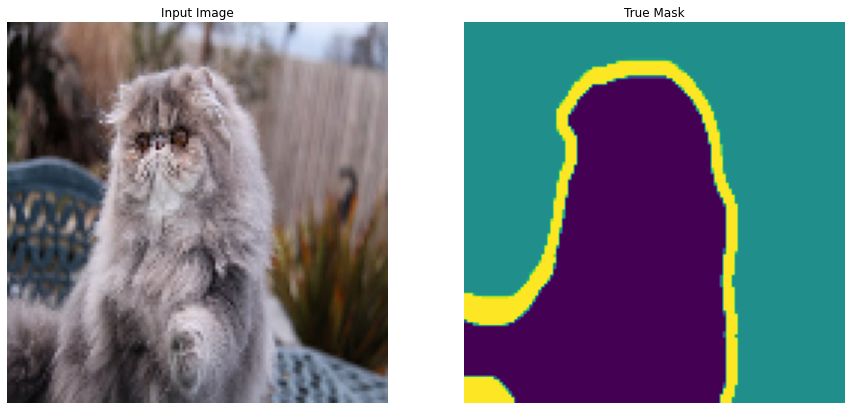

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

## Building the model

We will use a U-Net : it will consist of an encoder (downsampler) and a decoder (upsampler). For the encoder, we will use a pretrained model : the MobileNetV2. That way, we will learn robust features and reduce the number of paramaters to train. We will only train the decoder.

Let's start with the encoder.

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128,128,3],include_top=False)

# Defining the layers
layer_name = [
    'block_1_expand_relu',  # 64x64
    'block_3_expand_relu',  # 32x32
    'block_6_expand_relu',  # 16x16
    'block_13_expand_relu', # 8x8
    'block_16_project',     # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_name]

# Creating the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.traninable = False

9420800/9406464 [==============================] - 0s 0us/step


Next, our decoder will consist of a series of upsample blocks implemented in TensorFlow examples.
Each upsample block contains four layers : `Conv2DTranspose > BatchNormalization > Dropout > ReLU`.

In [ ]:
up_stack = [
    pix2pix.upsample(512,3), # 4x4 -> 8x8
    pix2pix.upsample(256,3), # 8x8 -> 16x16
    pix2pix.upsample(128,3), # 16x16 -> 32x32
    pix2pix.upsample(64,3)  # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128,128,3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack,skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x,skip])

    # Last layer of the model
    last = tf.keras.layers.Conv2DTranspose( # 64x64 -> 128x128
        filters=output_channels,
        kernel_size=3,
        strides=2,
        padding='same'
    )

    x = last(x)

    return tf.keras.Model(inputs=inputs,outputs=x)

## Training the model

This segmentation task is a multiclass classification problem : we are assigning a class (1, 2 or 3) to each pixel of the input image. That's why we will use the categorical cross-entropy loss function. As we are only giving one label to each pixel, and not a probability distribution over the classes, the argument `from_logits` will be set to `True`.

In [ ]:
OUTPUT_CLASSES = 3 #  Number of classes

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

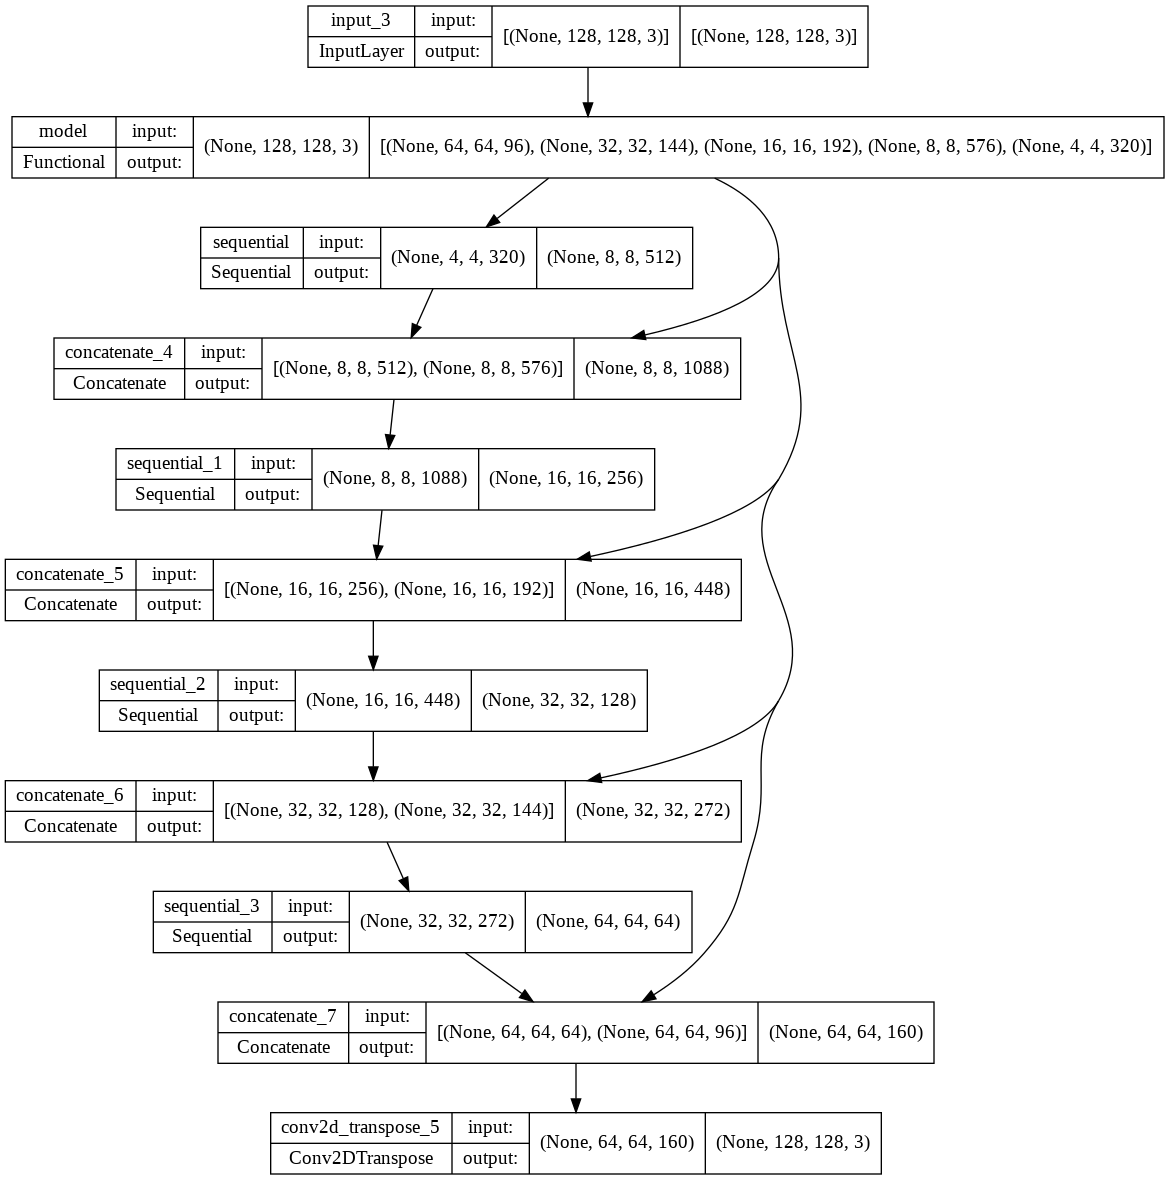

In [ ]:
# Plot the model architecture
tf.keras.utils.plot_model(model,show_shapes=True)

We can try out the model to see if it works. Of course, the resulting mask is far from the true mask as we didn't do any training.

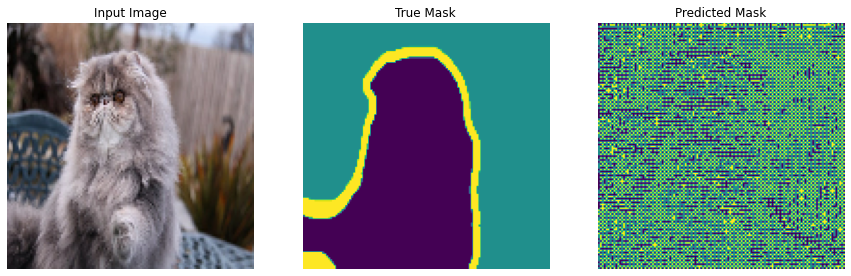

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask,axis=-1)
    pred_mask = pred_mask[...,tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None,num=1):
    if dataset:
        for image,mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0],mask[0],create_mask(pred_mask)])
    else:
        display([sample_image,sample_mask,create_mask(model.predict(sample_image[tf.newaxis,...]))])

show_predictions()

The following class will allow us to see how the model improves while it's training by plotting the prediction of a sample image.

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        clear_output(wait=True)
        show_predictions()
        print('\nSample Prediction after epoch {}'.format(epoch+1))

Let's now train our model.

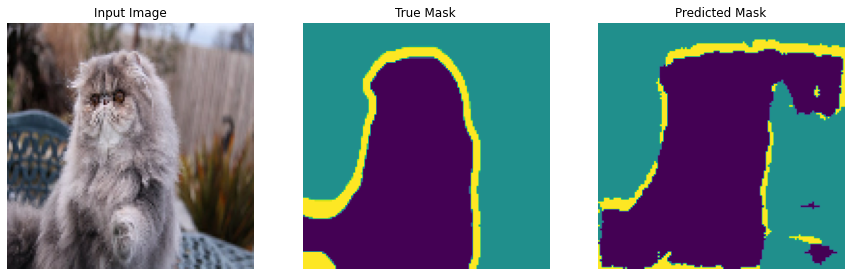


Sample Prediction after epoch 20
57/57 [==============================] - 16s 273ms/step - loss: 0.1146 - accuracy: 0.9462 - val_loss: 0.4553 - val_accuracy: 0.8521


In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

history = model.fit(
    train_batches,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_batches,
    callbacks=[DisplayCallback()]
)

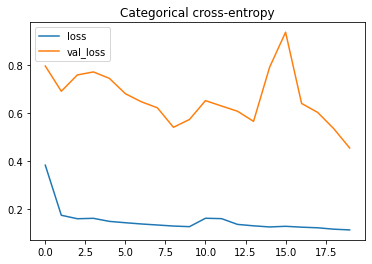

In [ ]:
import pandas as pd
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot(title='Categorical cross-entropy')

## Visualizing the results

We can now use our trained model to compute the mask of new test images.

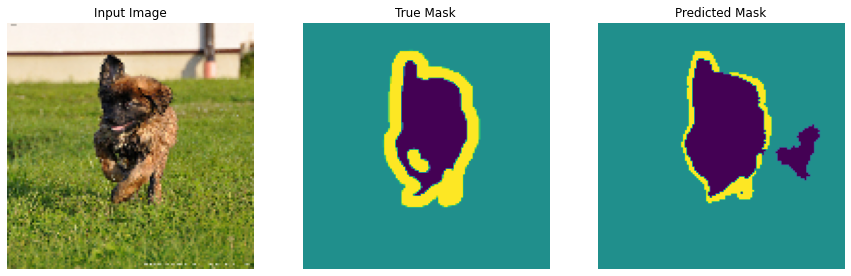

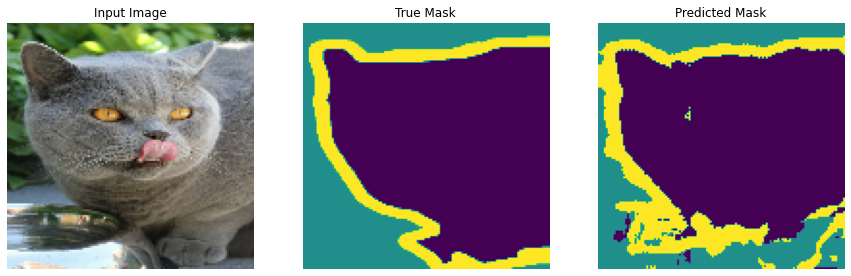

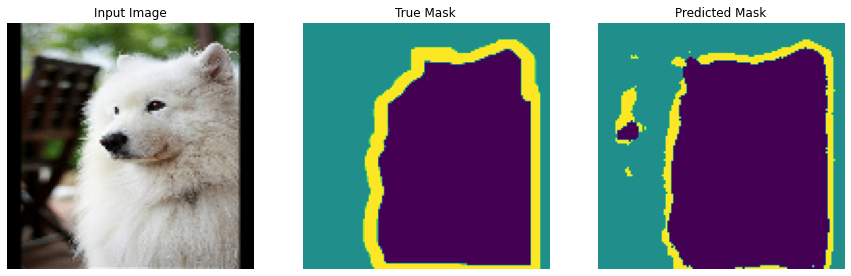

In [ ]:
show_predictions(test_batches,3)